In [1]:
import os
from utils import (
    create_client,
    create_schema,
    create_collection,
    load_images,
    create_index,
    search_by_image,
    search_by_text,
    draw_images,
)
import time
import matplotlib.pyplot as plt
from pymilvus import MilvusClient, db, connections
from clip_embeddings_generator import ClipEmbeddingsGenerator

In [2]:
connections.connect(host="milvus-standalone", port="19530")
if "avatares" not in db.list_database():
    db.create_database("avatares")
db.using_database("avatares")

In [3]:
config = {
    "index_type": "IVF_FLAT",
    "metric_type": "COSINE",
    "params": {"nlist": 8},
}

In [4]:
# Crear cliente y esquema
client: MilvusClient = create_client()
schema = create_schema()

# Inicializar el generador de embeddings
embedder = ClipEmbeddingsGenerator()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
image_dir = "images/"
image_paths = [
    os.path.join(image_dir, img)
    for img in os.listdir(image_dir)
    if img.endswith(".png")
]

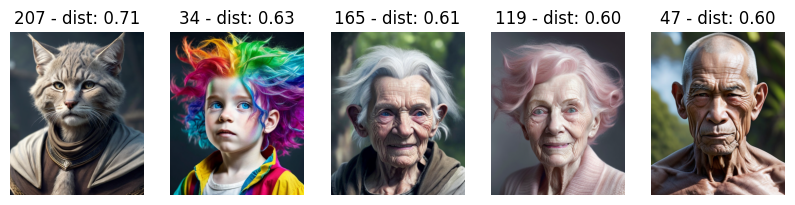

In [6]:
collection_name = f"avatar_{config['index_type']}_{config['metric_type']}"
create_collection(client, schema, collection_name)
load_images(embedder, client, collection_name)
create_index(client, collection_name, config=config)
client.load_collection(collection_name=collection_name)

image_path = "Avatar_cat.png"
search_results = search_by_image(client, collection_name, embedder, image_path=image_path)

result_ids = [result["id"] for result in search_results[0]]
image_paths_result = [image_paths[result_id] for result_id in result_ids]
result_titles = [
    f"{result['id']} - dist: {result['distance']:.2f}" for result in search_results[0]
]

draw_images(image_paths_result, result_titles)
plt.show()

client.release_collection(collection_name)